In [55]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS

In [56]:
# Tamanho do array
n = 0
# Matriz de distância
dist_df = []
# Matriz de custo
flow_df  = []

In [57]:
def gerar_array_replicavel(seed: int, tamanho: int) -> list[int]:
    random.seed(seed)
    vetor = list(range(tamanho))  # agora 0 até n-1
    random.shuffle(vetor)
    return vetor

In [58]:
def generate_neighborhood_1(sol: list[int]) -> list[list[int]]:
  neighborhood = []
  for i in range(len(sol)-1):
    neighbor = sol[:]
    neighbor[i], neighbor[i+1] = neighbor[i+1], neighbor[i]
    neighborhood.append(neighbor)
  return neighborhood


def generate_neighborhood_2(sol: list[int]) -> list[list[int]]:
  neighborhood = []
  for i in range(len(sol)-2):
    neighbor = sol[:]
    neighbor[i], neighbor[i+2] = neighbor[i+2], neighbor[i]
    neighborhood.append(neighbor)
  return neighborhood

In [59]:
def solution_score(sol: list[int], flow: list[list[float]], dist: list[list[float]]) -> float:
    """
    Calcula o custo total da solução `sol` para o Problema de Alocação Quadrática (QAP),
    com base na fórmula da função objetivo.

    Parâmetros:
    - sol (list[int]): permutação das instalações (índices), onde sol[i] é a instalação na posição i
    - flow (list[list[float]]): matriz de fluxo entre instalações
    - dist (list[list[float]]): matriz de distâncias entre localizações

    Retorna:
    - float: custo total da solução
    """
    n = len(sol)
    if len(flow) != n or len(dist) != n:
        raise ValueError("Tamanhos incompatíveis entre solução, fluxo e distância")

    score = 0.0
    for i in range(n):
        for j in range(n):
            a = sol[i]
            b = sol[j]
            score += flow[a][b] * dist[i][j]
    return score


In [60]:
def ler_qap_com_n(caminho: str):
    with open(caminho, "r") as f:
        dados = list(map(int, f.read().split()))

    # O primeiro número é o tamanho da matriz
    n = dados[0]
    valores = dados[1:]  # O resto são os valores das duas matrizes

    total_esperado = 2 * n * n
    if len(valores) != total_esperado:
        raise ValueError(f"Esperado {total_esperado} valores, mas encontrado {len(valores)}.")

    # Separar em duas matrizes
    flow_flat = valores[:n * n]
    dist_flat = valores[n * n:]

    # Converter para DataFrames
    flow_df = pd.DataFrame([flow_flat[i * n:(i + 1) * n] for i in range(n)])
    dist_df = pd.DataFrame([dist_flat[i * n:(i + 1) * n] for i in range(n)])

    return n, flow_df, dist_df

# Exemplo de uso
n, flow_df, dist_df = ler_qap_com_n("bur26b.txt")

# Converter para listas
flow = flow_df.values.tolist()
dist = dist_df.values.tolist()

In [61]:
solucao_inicial = gerar_array_replicavel(seed=42, tamanho=n)
solucao_inicial

[16,
 12,
 9,
 25,
 19,
 6,
 5,
 10,
 15,
 22,
 11,
 18,
 1,
 14,
 23,
 13,
 2,
 17,
 24,
 4,
 21,
 7,
 8,
 0,
 3,
 20]

In [62]:
solution_score(solucao_inicial, flow_df, dist_df)

np.float64(4176643.0)

In [63]:
def plotar_solucao(solucao, flow_df, dist_df, titulo="Solução QAP Dinâmica"):
    n = len(solucao)
    dist_array = np.array(dist_df)

    # Reordenar matriz de distâncias conforme a solução
    dist_reordenada = dist_array[np.ix_(solucao, solucao)]

    # Força simetria
    dist_reordenada = (dist_reordenada + dist_reordenada.T) / 2

    # Zera diagonal
    np.fill_diagonal(dist_reordenada, 0)


    # Gerar coordenadas MDS da matriz reordenada
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    coords = mds.fit_transform(dist_reordenada)

    plt.figure(figsize=(8, 6))

    # Conectar na ordem original da solução (0..n-1) pois coords já estão ordenadas segundo solucao
    for i in range(n):
        origem = i
        destino = (i + 1) % n
        plt.plot(
            [coords[origem, 0], coords[destino, 0]],
            [coords[origem, 1], coords[destino, 1]],
            color="blue"
        )

    plt.scatter(coords[:, 0], coords[:, 1], color="#add8e6", s=300, edgecolors="black", zorder=3)

    for i in range(n):
        plt.annotate(str(solucao[i]), (coords[i, 0], coords[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.title(titulo)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


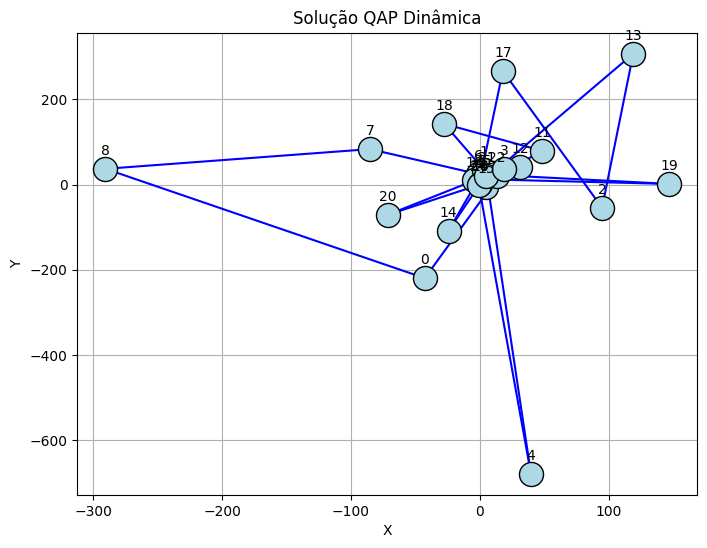

In [64]:
plotar_solucao(solucao_inicial, flow_df, dist_df)

In [65]:
def get_best_solution(neighborhood, flow, dist):
    best_sol = None
    best_score = float('inf')
    for sol in neighborhood:
        score = solution_score(sol, flow, dist)
        if score < best_score:
            best_score = score
            best_sol = sol
    return best_sol


In [66]:
def print_solution(sol: list[int], flow, dist) -> None:
    print("Solution:", sol)
    print("Score:", f"{solution_score(sol, flow, dist):.2f}")
    print()


neighborhood_generators = [generate_neighborhood_1, generate_neighborhood_2]
r = len(neighborhood_generators)

curr_sol = solucao_inicial
k = 0
while k < r:
    neighborhood = neighborhood_generators[k](curr_sol)
    best_neighbor = get_best_solution(neighborhood, flow_df.values.tolist(), dist_df.values.tolist())
    if solution_score(best_neighbor, flow_df.values.tolist(), dist_df.values.tolist()) < \
       solution_score(curr_sol, flow_df.values.tolist(), dist_df.values.tolist()):
        print_solution(curr_sol, flow_df.values.tolist(), dist_df.values.tolist())
        curr_sol = best_neighbor
        k = 0
    else:
        k += 1

print_solution(curr_sol, flow_df.values.tolist(), dist_df.values.tolist())


Solution: [16, 12, 9, 25, 19, 6, 5, 10, 15, 22, 11, 18, 1, 14, 23, 13, 2, 17, 24, 4, 21, 7, 8, 0, 3, 20]
Score: 4176643.00

Solution: [16, 9, 12, 25, 19, 6, 5, 10, 15, 22, 11, 18, 1, 14, 23, 13, 2, 17, 24, 4, 21, 7, 8, 0, 3, 20]
Score: 4138735.00

Solution: [16, 9, 12, 25, 19, 6, 5, 10, 15, 22, 11, 18, 1, 14, 23, 13, 2, 17, 4, 24, 21, 7, 8, 0, 3, 20]
Score: 4129869.00

Solution: [16, 9, 12, 25, 19, 6, 5, 10, 15, 22, 11, 18, 1, 14, 13, 23, 2, 17, 4, 24, 21, 7, 8, 0, 3, 20]
Score: 4122502.00

Solution: [16, 9, 12, 25, 19, 6, 5, 10, 15, 22, 11, 18, 1, 13, 14, 23, 2, 17, 4, 24, 21, 7, 8, 0, 3, 20]
Score: 4048571.00

Solution: [16, 9, 12, 25, 19, 6, 5, 10, 15, 22, 18, 11, 1, 13, 14, 23, 2, 17, 4, 24, 21, 7, 8, 0, 3, 20]
Score: 4043995.00

Solution: [16, 9, 12, 25, 19, 6, 5, 10, 15, 22, 18, 11, 1, 13, 14, 2, 23, 17, 4, 24, 21, 7, 8, 0, 3, 20]
Score: 4042470.00

Solution: [16, 9, 12, 25, 19, 6, 5, 10, 15, 22, 18, 11, 1, 13, 2, 14, 23, 17, 4, 24, 21, 7, 8, 0, 3, 20]
Score: 4034523.00

Solution

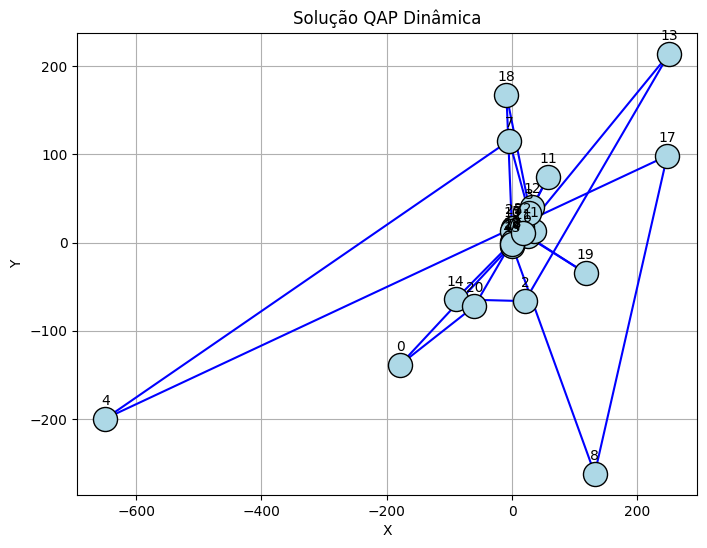

In [67]:
plotar_solucao(curr_sol, flow_df.values.tolist(), dist_df.values.tolist())